In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.5'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15886841310561139270
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 3281970790
locality {
  bus_id: 1
}
incarnation: 5351812928928516139
physical_device_desc: "device: 0, name: Quadro M1200, pci bus id: 0000:01:00.0"
]


In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import LSTM, Activation, Dropout, SimpleRNN, Bidirectional, Conv1D, GRU, Add, BatchNormalization, Activation
from keras.layers.core import Flatten
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
#import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [207]:
data = pd.read_csv("AAPL.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-06-27,23.787144,24.367144,23.450001,24.298571,16.385893,260562400
1,2008-06-30,24.312857,24.571428,23.802856,23.920000,16.130606,171049200
2,2008-07-01,23.461428,24.959999,23.428572,24.954287,16.828079,277820200
3,2008-07-02,25.028572,25.350000,24.025715,24.025715,16.201887,209379800
4,2008-07-03,24.227142,24.595715,23.678572,24.302856,16.388779,130840500


In [208]:
btc_trace = go.Scatter(x=data.index, y=data['Close'], name= 'Price')
py.iplot([btc_trace])

In [209]:
data['Close'].replace(0, np.nan, inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

In [210]:
btc_trace = go.Scatter(x=data.index, y=data['Close'], name= 'Price')
py.iplot([btc_trace])

In [7]:
from sklearn.preprocessing import MinMaxScaler
values = data['Weighted Price'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

965 415


In [15]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [16]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

964
414


In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, nb_epoch=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

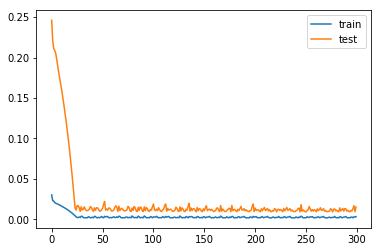

In [13]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

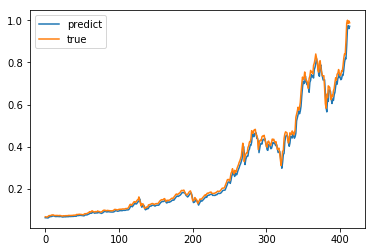

In [14]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [15]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [16]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 117.860


In [17]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
%matplotlib inline
pyplot.show()

In [18]:
predictDates = data.tail(len(testX)).index

In [19]:
predictDates

Index(['8/30/2016', '8/31/2016', '9/1/2016', '9/2/2016', '9/3/2016',
       '9/4/2016', '9/5/2016', '9/6/2016', '9/7/2016', '9/8/2016',
       ...
       '10/8/2017', '10/9/2017', '10/10/2017', '10/11/2017', '10/12/2017',
       '10/13/2017', '10/14/2017', '10/15/2017', '10/16/2017', '10/17/2017'],
      dtype='object', name='Date', length=414)

In [20]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [22]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

In [178]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
Data=np.empty((0,4))
for i in range(len(values)):
    Data.append()
    

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [257]:
#values = data[['Weighted'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = data[['Open'] + ['High'] + ['Low'] + ['Close']].values
values = values.astype('float32')

In [267]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [268]:
from keras.preprocessing.sequence import TimeseriesGenerator
data_gen = TimeseriesGenerator(scaled, scaled[:,-1],
                               length=3, sampling_rate=1,
                               stride=3, batch_size=len(scaled))
X, y = data_gen[0]
X.shape, y.shape

((630, 4, 4), (630,))

In [269]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X[:600], y[:600], test_size=0.1, random_state=42, shuffle=True)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(540, 4, 4) (540,) (60, 4, 4) (60,)


In [103]:
train_X = X[:700]
test_X = X[700:]
train_y = y[:700]
test_y = y[700:]
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((700, 3, 4), (700,), (140, 3, 4), (140,))

In [27]:
reframed = series_to_supervised(scaled, 2, 2)
reframed.head()

,var1(t-2),var1(t-1),var1(t),var1(t+1)
2,0.071808,0.069737,0.075395,0.070316
3,0.069737,0.075395,0.070316,0.071832
4,0.075395,0.070316,0.071832,0.075770
5,0.070316,0.071832,0.075770,0.079201
6,0.071832,0.075770,0.079201,0.075059


In [24]:
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
print(reframed.head())

IndexError: index 4 is out of bounds for axis 0 with size 4

In [28]:
values = reframed.values
n_train_hours = int(len(values) * 0.9)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
#train_y = train_y.reshape(train_y.shape[0],1)
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])
#test_y = test_y.reshape(test_y.shape[0],1)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2268, 2, 1) (2268, 2) (253, 2, 1) (253, 2)


In [270]:
from keras.callbacks import ReduceLROnPlateau
def tcn(h,filters=200, kernel_size=10, padding='causal', activation='relu', dilation_rate=1):
    #main = BatchNormalization()(h)
    main = h
    for i in range(2):
        main = Conv1D(filters=filters,kernel_size=kernel_size,padding=padding, dilation_rate=dilation_rate)(main)
        #main = BatchNormalization()(main)
        main = Activation('relu')(main)
        main = Dropout(0.2)(main)
    side_path = Conv1D(filters=filters,kernel_size=1, padding='same')(h)
    #side_path = BatchNormalization()(side_path)
    return Add()([main,side_path])

Inp = Input(shape=(4,4))
inp = Inp
D = [1,1,2]
for i in range(1):
    inp=tcn(inp,dilation_rate=D[i])
    #inp = BatchNormalization()(inp)
    #inp = Activation('relu')(inp)
inp=Flatten()(inp)
out=Dense(1)(inp)
# inp = BatchNormalization()(inp)
# out = Conv1D(padding="causal", filters=10, kernel_size=1)(inp)
# inp = BatchNormalization()(inp)
# inp = Activation('relu')(inp)
# out = Flatten()(out)
# out = Dense(1)(out)
model = Model(Inp,out)
#model=Sequential()
#model.add(Conv1D(filters=10,kernel_size=1, input_shape=(5,4), padding='causal',activation='relu'))
#model.add(Dense(12, input_dim=4,activation='relu'))
#model.add(Flatten())
#model.add(Dense(1))
ad = optimizers.Adam(lr=0.00002)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8)
model.compile(loss='mae', optimizer=ad)
history = model.fit(train_X, train_y, epochs=500, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=True)


In [161]:
from keras.callbacks import ReduceLROnPlateau
multi_model = Sequential()
multi_model.add(GRU(300, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
multi_model.add(GRU(200,dropout_U=0.1))
multi_model.add(Dense(1))
ad = optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)
multi_model.compile(loss='mae', optimizer=ad)
multi_history = multi_model.fit(train_X, train_y, nb_epoch=300, batch_size=100, callbacks=[reduce_lr],  validation_data=(test_X, test_y), verbose=0, shuffle=True)

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning:

Update your `GRU` call to the Keras 2 API: `GRU(200, recurrent_dropout=0.1)`

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\models.py:942: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



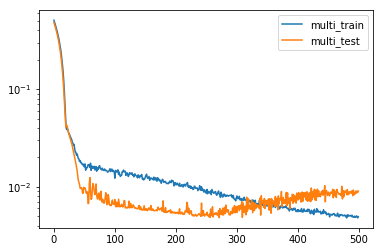

In [271]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.yscale('log')
pyplot.legend()
pyplot.show()

In [273]:
pred=model.predict(X[600:])
pred

array([[ 0.87824595],
       [ 0.89408398],
       [ 0.86666971],
       [ 0.83206439],
       [ 0.78587067],
       [ 0.78876752],
       [ 0.85770643],
       [ 0.86725777],
       [ 0.88402766],
       [ 0.87792438],
       [ 0.90625471],
       [ 0.88297606],
       [ 0.83664733],
       [ 0.83915502],
       [ 0.85724038],
       [ 0.86154681],
       [ 0.88288659],
       [ 0.82917476],
       [ 0.81165075],
       [ 0.87697768],
       [ 0.93432838],
       [ 0.93844962],
       [ 0.94043231],
       [ 0.94524616],
       [ 0.94481283],
       [ 0.97287208],
       [ 0.96274352],
       [ 0.93414891],
       [ 0.91995937],
       [ 0.92764598]], dtype=float32)

In [81]:
pred=np.zeros(7)
pred[0] = model.predict(test_X[-7,:,:].reshape(1,7,1))
print(pred[0])
np.concatenate((test_X[-7+1,:,:][:6],pred[1-1].reshape(1,1)))

0.923180162907


array([[ 0.9214952 ],
       [ 0.92764485],
       [ 0.92716444],
       [ 0.93465936],
       [ 0.92985487],
       [ 0.93264151],
       [ 0.92318016]])

In [84]:
test_X[-7+i,:,:]

array([[ 0.9214952 ],
       [ 0.92764485],
       [ 0.92716444],
       [ 0.93465936],
       [ 0.92985487],
       [ 0.93264151],
       [ 0.92758048]])

In [85]:
pred=np.zeros(7)
pred[0]=model.predict(test_X[-7,:,:].reshape(1,7,1))
for i in range(1,7):
    test_X[-7+i,:,:] = np.concatenate((test_X[-7+i,:,:][:6],pred[i-1].reshape(1,1)))
    pred[i]=model.predict(test_X[-7+i,:,:].reshape(1,7,1))

In [64]:
test_y[-10:,:]

array([[ 0.87231851,  0.87194264],
       [ 0.4521839 ,  0.44893172],
       [ 0.62948287,  0.63240242],
       [ 0.41201478,  0.41344574],
       [ 0.19144413,  0.19298875],
       [ 0.98583138,  0.9826048 ],
       [ 0.00457178,  0.00178954],
       [ 0.01019076,  0.00931497],
       [ 0.46722776,  0.46939036],
       [ 0.38106737,  0.37756902]])

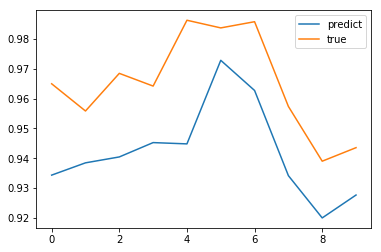

In [274]:
pyplot.plot(pred[-10:,:].reshape(10,1), label='predict')
pyplot.plot(y[-10:].reshape(10,1), label='true')
#pyplot.plot(test_y[-100:,-2].reshape(100,1), label='true')
pyplot.legend()
pyplot.show()

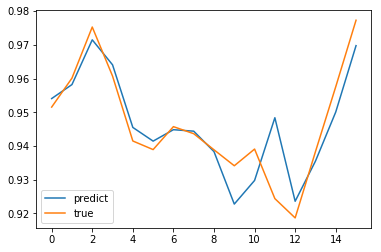

In [196]:
pyplot.plot(pred[:,:].reshape(16,1), label='predict')
pyplot.plot(y[1990:].reshape(16,1), label='true')
#pyplot.plot(test_y[-100:,-2].reshape(100,1), label='true')
pyplot.legend()
pyplot.show()

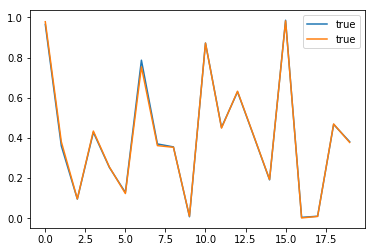

In [66]:
yhat = model.predict(test_X)
pyplot.plot(yhat[-20:], label='predict')
pyplot.plot(test_y[-20:], label='true')
pyplot.legend()
pyplot.show()

In [38]:
np.concatenate((test_y.reshape(len(test_y),1),yhat),axis=1)

array([[ 0.0998207 ,  0.09953785],
       [ 0.09900345,  0.09956556],
       [ 0.09862069,  0.09925415],
       [ 0.0995    ,  0.09884549],
       [ 0.10362069,  0.09883162],
       [ 0.10512759,  0.10113217],
       [ 0.1051507 ,  0.10451192],
       [ 0.10551741,  0.10517173],
       [ 0.10643708,  0.10534364],
       [ 0.10881363,  0.10590086],
       [ 0.10794827,  0.10763298],
       [ 0.10773948,  0.10813697],
       [ 0.10487173,  0.10809268],
       [ 0.10536328,  0.1059481 ],
       [ 0.10608432,  0.10550532],
       [ 0.10585707,  0.10578594],
       [ 0.10516586,  0.10596894],
       [ 0.10482414,  0.10569417],
       [ 0.10462069,  0.1054226 ],
       [ 0.10551535,  0.10503548],
       [ 0.10503449,  0.10550596],
       [ 0.10410345,  0.10541973],
       [ 0.10338794,  0.10497598],
       [ 0.10259534,  0.10348967],
       [ 0.1041669 ,  0.1032221 ],
       [ 0.10413776,  0.10348474],
       [ 0.10344793,  0.10438864],
       [ 0.10499655,  0.10380632],
       [ 0.10456983,

In [27]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

ValueError: all the input arrays must have same number of dimensions

In [40]:
np.concatenate((inv_y.reshape(len(inv_y),1),inv_yhat.reshape(len(inv_yhat),1)),axis=1)

array([[  578.96002197,   577.31951904],
       [  574.2199707 ,   577.48022461],
       [  572.        ,   575.67401123],
       [  577.09997559,   573.30383301],
       [  601.        ,   573.22332764],
       [  609.73999023,   586.56658936],
       [  609.87402344,   606.16912842],
       [  612.00097656,   609.99597168],
       [  617.33502197,   610.99310303],
       [  631.11901855,   614.22497559],
       [  626.09997559,   624.27124023],
       [  624.88897705,   627.19445801],
       [  608.25598145,   626.9375    ],
       [  611.10699463,   614.4989624 ],
       [  615.28900146,   611.93084717],
       [  613.9710083 ,   613.55847168],
       [  609.9619751 ,   614.61981201],
       [  607.97998047,   613.02618408],
       [  606.79998779,   611.4510498 ],
       [  611.98901367,   609.20581055],
       [  609.20001221,   611.93450928],
       [  603.79998779,   611.43444824],
       [  599.65002441,   608.86065674],
       [  595.05297852,   600.24005127],
       [  604.16

In [41]:
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[1:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 57.445


In [42]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])